In [1]:
from IPython.display import clear_output
!pip install albumentations -U
clear_output()

In [1]:
import os
import torch
import random
import collections
from PIL import Image
import torch.nn as nn
import torch.optim as optim

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from tqdm import trange

import torchvision
import torchvision.utils as tutils
import torchvision.datasets as tdataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import albumentations as A

import matplotlib.animation as animation
from IPython.display import HTML

from typing import Union

SEED = 13

def set_seed(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(A.__version__, torch.__version__)

1.1.0 1.9.0+cu111


In [5]:
def imshow(img: Union[torch.tensor, list]):
    if isinstance(img, torch.Tensor):
        npimg = img.detach().cpu().numpy()
    else:
        npimg = img.numpy()
    npimg = np.squeeze(npimg)
    plt.imshow((np.transpose(npimg, (1, 2, 0)) * 0.5) + 0.5)
    plt.xticks([])
    plt.yticks([])


class S7Data(Dataset):

    def __init__(self, data: dict, transform = None):
        super().__init__()
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        key = list(self.data.keys())[idx]
        paths = self.data[key]
        data, target = np.array(Image.open(paths[0])), np.array(Image.open(paths[1]))
        if self.transform:            
            sample = self.transform(image=data, image0=target)
            img = sample['image']
            target = sample['image0']
        img = img.transpose(2, 0, 1).astype(np.float32)  
        target = target.transpose(2, 0, 1).astype(np.float32)  
        return torch.tensor(img, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


class DBlock(nn.Module):

    def __init__(self, input: int, out:int, stride: int = 2):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input, out, 4, stride, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.block(x)


class UBlock(nn.Module):
    def __init__(
        self,
        input: int,
        out: int,
        act: str = 'relu',
        down: bool = True, 
        dropout: bool = False
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(input, out, 4, 2, 1, bias=False, padding_mode='reflect')
            if down
            else nn.ConvTranspose2d(input, out, 4, 2, 1, bias = False),
            nn.BatchNorm2d(out),
            nn.ReLU() if act == 'relu' else nn.LeakyReLU(0.2),
        )
        self.dropout = dropout
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = self.block(x)
        if self.dropout:
            return self.drop(x)
        return x


class Discriminator(nn.Module):
    
    def __init__(self, input: int, dim: list = [64, 128, 256, 512]):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input, dim[0], 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            )
        layer = []
        for i in range(1, len(dim)):
            layer.append(
                DBlock(dim[i-1], dim[i], stride = 1 if dim[i] == dim[-1] else 2)
                )
            # out shape torch.Size([1, 512, 27, 27])
        layer.append(
            nn.Conv2d(dim[-1], 1, 4, 1, 1, padding_mode='reflect')
        )
        self.model = nn.Sequential(*layer)

    def forward(self, x, y):
        # x real, y fake
        x = torch.cat((x, y), dim = 1) #torch.Size([1, 6, 256, 256])
        x = self.conv1(x)
        x = self.model(x) #out torch.Size([1, 1, 26, 26])
        return x


class Generator(nn.Module):
    def __init__(self, input: int, out: int = 64):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(input, out, 4, 2, 1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )
        # 64, 32, 16, 8, 4 <- 1x1 -> 4, 8, 16, 32, 64
        self.down1 = UBlock(out,     out * 2, act = 'lky' , down = True, dropout =False)
        self.down2 = UBlock(out * 2, out * 4, act = 'lky' , down = True, dropout =False)
        self.down3 = UBlock(out * 4, out * 8, act = 'lky' , down = True, dropout =False)
        self.down4 = UBlock(out * 8, out * 8, act = 'lky' , down = True, dropout =False)
        self.down5 = UBlock(out * 8, out * 8, act = 'lky' , down = True, dropout =False)
        self.down6 = UBlock(out * 8, out * 8, act = 'lky' , down = True, dropout =False)
        self.center = nn.Sequential(
            nn.Conv2d(out * 8, out * 8, 4, 2, 1, padding_mode='reflect'), nn.ReLU(),
        )
        self.up1 = UBlock(out * 8,     out * 8, act = 'relu' , down = False, dropout = True)
        self.up2 = UBlock(out * 8 * 2, out * 8, act = 'relu' , down = False, dropout = True)
        self.up3 = UBlock(out * 8 * 2, out * 8, act = 'relu' , down = False, dropout = True)
        self.up4 = UBlock(out * 8 * 2, out * 8, act = 'relu' , down = False, dropout = False)
        self.up5 = UBlock(out * 8 * 2, out * 4, act = 'relu' , down = False, dropout = False)
        self.up6 = UBlock(out * 4 * 2, out * 2, act = 'relu' , down = False, dropout = False)
        self.up7 = UBlock(out * 2 * 2, out,     act = 'relu' , down = False, dropout = False)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(out*2, input, 4, 2, 1, bias = False),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.conv1(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        center = self.center(d7)
        u1 = self.up1(center)
        u2 = self.up2(torch.cat((u1, d7), dim = 1))
        u3 = self.up3(torch.cat((u2, d6), dim = 1))
        u4 = self.up4(torch.cat((u3, d5), dim = 1))
        u5 = self.up5(torch.cat((u4, d4), dim = 1))
        u6 = self.up6(torch.cat((u5, d3), dim = 1))
        u7 = self.up7(torch.cat((u6, d2), dim = 1))
        final = self.final(torch.cat((u7, d1), dim = 1))
        return final


In [3]:
x = torch.randn(1, 3, 256, 256)
y = torch.randn(1, 3, 256, 256)
d = Discriminator(6)
d(x, y).shape

torch.Size([1, 1, 26, 26])

In [4]:
g = Generator(3, 64)
x = torch.randn(1, 3, 256, 256)
g(x).shape

torch.Size([1, 3, 256, 256])

In [7]:
path_tr = '/content/drive/MyDrive/TZ/Huawei/input/s7/tr'
path_vl = '/content/drive/MyDrive/TZ/Huawei/input/s7/vl'
tmp_tr = collections.defaultdict(list)
tmp_vl = collections.defaultdict(list)
"""
tmp['20161107_232916']
    [PosixPath('/content/drive/MyDrive/TZ/Huawei/input/s7/20161107_232916/short_exposure.jpg'),
     PosixPath('/content/drive/MyDrive/TZ/Huawei/input/s7/20161107_232916/medium_exposure.jpg')]
"""
for i in Path(path_tr).glob(f'*/*.jpg'):
    tmp_tr[str(i.parent.name)].append(i)

for i in Path(path_vl).glob(f'*/*.jpg'):
    tmp_vl[str(i.parent.name)].append(i)

In [6]:
def tr_transform():
  return A.Compose([A.Resize(width= 256, height=256),
                    A.HorizontalFlip(p=0.5),
                    # A.ColorJitter(p=0.2),
                    A.Normalize(
                        mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5],
                        max_pixel_value=255.0),           
                    ],
                    additional_targets={"image0": "image"}                
                   )

def vl_transform():  
  return A.Compose([A.Resize(width= 256, height=256),
                    A.Normalize(
                        mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5],
                        max_pixel_value=255.0),
                    ],        
                   additional_targets={"image0": "image"}                   
                   )

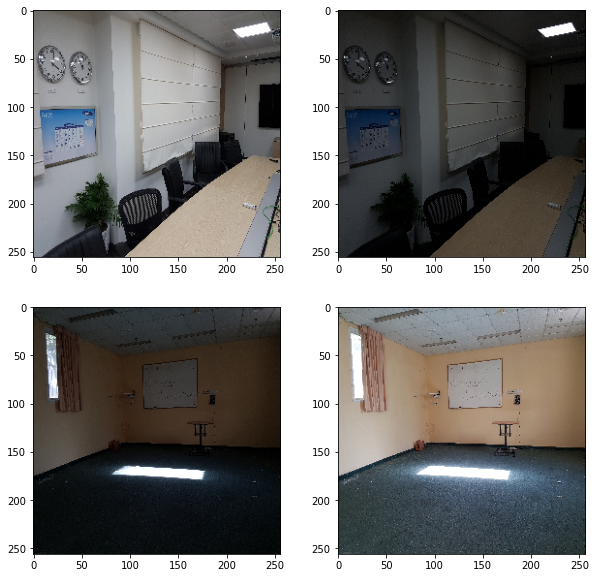

In [13]:
d = S7Data(tmp_tr, tr_transform())
tr_loader = DataLoader(
    d,
    batch_size=2,
    shuffle = True
)

real_samples = next(iter(tr_loader))
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i in range(2):
    img1 = np.transpose(real_samples[0][i], (1,2,0))
    img2 = np.transpose(real_samples[1][i], (1,2,0))
    img1 = (img1 * 0.5) + 0.5
    img2 = (img2 * 0.5) + 0.5
    axs[i, 0].imshow(img1)
    axs[i, 1].imshow(img2)

In [ ]:
num_epochs = 1
lr = 2e-4
beta1 = 0.5
discriminator = Discriminator(6).to(device=device)
generator = Generator(3, 64).to(device=device)

loss_func_bce = nn.BCEWithLogitsLoss()
loss_func_l1 = nn.L1Loss()
optD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

tr_dset = S7Data(tmp_tr, tr_transform())
vl_dset = S7Data(tmp_vl, vl_transform())
tr_loader = DataLoader(tr_dset, batch_size=4, shuffle = True)
vl_loader = DataLoader(vl_dset, batch_size=1, shuffle = False)

In [ ]:
iter = 0
for e in range(num_epochs):
    d_tmp, g_tmp = train_one_epoch(
            discriminator,
            generator,
            tr_loader,
            optD,
            optG,
            loss_func_bce,
            loss_func_l1
    ) 
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x)'
            % (e, num_epochs, np.mean(d_tmp), np.mean(g_tmp))
    )
    if (iters % 5 == 0) or (e == num_epochs-1):
        fake = torch.randn(batch, 100, 1, 1, device=device)
            with torch.no_grad():
                fake = generator(fake).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

In [ ]:
def train_one_epoch(
    discriminator: nn.Module,
    generator: nn.Module,
    loader: DataLoader,
    optD: optim.Adam,
    optG: optim.Adam,
    loss_func_bce: nn.modules.loss,
    loss_func_l1: nn.modules.loss
):  
    d_tmp, g_tmp = [], []
    for x, y in tqdm(loader):
        x, y = x.to(device=device), y.to(device=device)
        fake = generator(x)
        d_real = discriminator(x, y)
        d_fake = discriminator(x, fake.detach())
        loss_real = loss_func_bce(d_real, torch.ones_like(d_real))
        loss_fake = loss_func_bce(d_fake, torch.zeros_like(d_fake))
        dloss = (loss_real + loss_fake) / 2
        discriminator.zero_grad() 
        dloss.backward()
        optD.step()

        d_fake = discriminator(x, fake)
        loss_fake = loss_func_bce(d_fake, torch.ones_like(d_fake))
        loss_l1 = loss_func_l1(fake, y) * 100
        gloss = loss_fake + loss_l1
        optG.zero_grad() 
        gloss.backward()
        optG.step()
        # print(dloss.detach().cpu().numpy())
        d_tmp.append(dloss.detach().cpu().numpy())
        g_tmp.append(gloss.detach().cpu().numpy())
    return d_tmp, g_tmp

In [ ]:
img_list = []
iters = 0
for e in range(num_epochs):
    for real in tqdm(tr_loader):         
        if (iters % 5 == 0) or ((e == num_epochs-1) and (i == len(tr_loader)-1)):
            fake = torch.randn(batch, 100, 1, 1, device=device)
            with torch.no_grad():
                fake = generator(fake).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))
    break

In [ ]:
vl = iter(vl_loader)

In [ ]:
x, y = vl.next()
generator.eval()
x, y = x.to(device=device), y.to(device=device)
with torch.no_grad():
    y_fake = generator(x)
    y_fake = y_fake * 0.5 + 0.5 
    x = x * 0.5 + 0.5 
    y = y * 0.5 + 0.5

([], <a list of 0 Text major ticklabel objects>)

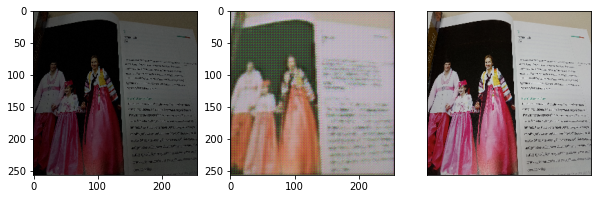

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,10))
img1 = np.transpose(y_fake[0], (1,2,0))
img2 = np.transpose(y[0], (1,2,0))
img3 = np.transpose(x[0], (1,2,0))
axs[0].imshow(img3)
axs[1].imshow(img1)
axs[2].imshow(img2)
plt.xticks([])
plt.yticks([])

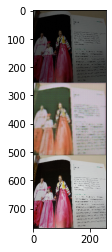

In [ ]:
grid = torchvision.utils.make_grid(torch.tensor(np.vstack((img3,img1,img2))), padding=2, normalize=True)
plt.imshow(grid)